## Enerthon Nano Grid Home Challenge: co-optimization of power and heat building consumption

https://www.enerthon.com/challenges

## Installation
We need to install pyomo [1] and GLPK solver [2]. Pyomo is used to create the optimization model and GLPK to solve the model.

1. http://www.pyomo.org/
2. https://www.gnu.org/software/glpk/

In [39]:
!pip install -q pyomo==5.7.3
!apt-get install -y -qq glpk-utils

We clone the model source code from the repository.

In [40]:
!git clone https://github.com/rebaseenergy/enerthon-project.git


Cloning into 'enerthon-project'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 7), reused 30 (delta 3), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [41]:
%cd enerthon-project/
!ls

/content/enerthon-project/enerthon-project/enerthon-project
data  enerthon	README.md  setup.py  test


Finally we import all required modules.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enerthon.enerthon_model import model, model_input, model_results, solve_model

## Import data
We import load, PV generation and heat demand data.

In [43]:
# Import data
df = pd.read_csv('./data/data.zip', header = 0, index_col=0, parse_dates = True)

In [44]:
print(df)

                            PV  Load   Heat
valid_datetime                             
2019-01-01 00:00:00+00:00  0.0  2.41  10.30
2019-01-01 01:00:00+00:00  0.0  2.29   9.57
2019-01-01 02:00:00+00:00  0.0  2.28   9.71
2019-01-01 03:00:00+00:00  0.0  2.27   9.84
2019-01-01 04:00:00+00:00  0.0  2.48   9.90
...                        ...   ...    ...
2019-12-31 19:00:00+00:00  0.0  5.28  19.40
2019-12-31 20:00:00+00:00  0.0  5.29  20.12
2019-12-31 21:00:00+00:00  0.0  4.80  20.73
2019-12-31 22:00:00+00:00  0.0  4.18  21.63
2019-12-31 23:00:00+00:00  0.0  3.67  22.64

[8760 rows x 3 columns]


We make the time series plots.

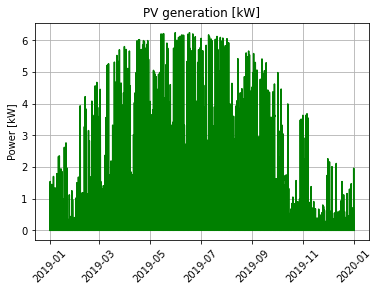

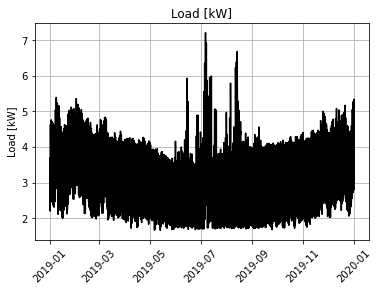

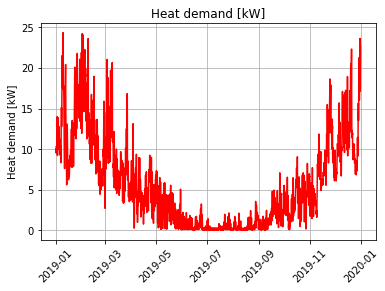

In [45]:
# Make time series plots
plt.plot(df['PV'],color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('Power [kW]')
plt.title('PV generation [kW]')
plt.grid()
plt.show() 

plt.plot(df['Load'],color = 'black')
plt.xticks(rotation = 45)
plt.ylabel('Load [kW]')
plt.title('Load [kW]')
plt.grid()
plt.show() 

plt.plot(df['Heat'],color = 'red')
plt.xticks(rotation = 45)
plt.ylabel('Heat demand [kW]')
plt.title('Heat demand [kW]')
plt.grid()
plt.show() 

We assign a unique value for every month in the data set. This is needed in order for the model to calculate the monthly grid power fee.

In [46]:
# Assign value to every unique month-year
df['TM'] = df.index.month
df['TY'] = df.index.year
df['month_order'] = df['TM'] + (df['TY'] - df['TY'][0])*12 - df['TM'][0]+1
df = df.drop(columns=['TM', 'TY'])

We set the prices for buying and selling electricity from the grid. In this example a fixed price for every period is considered but it is possible to have variable prices.

In [47]:
# Set electicity prices
df['price_buy'] = 0.08 # Є/kWh
df['price_sell'] = 0.04 # Є/kWh

We set the grid fees. In this case we assume a time-of-use (ToU) grid fee structure. Specifically the grid fee is 0.058 Є/kWh in the weekdays between 08:00 and 22:00 and for months November till March. For the rest of the periods of the year the fee is 0.009 Є/kWh. There is also a fixed charge of 25.5 Є/month. Finally, these fees are applied only for the power which is imported while for the exported power there are no fees. 

In [48]:
fixed_charge = 25.5 # Є/Month

df['grid_energy_import_fee'] = 0.009 # Є/kWh
df['grid_energy_export_fee'] = 0 # Є/kWh
df['grid_power_import_fee'] = 0 # Є/kW-month
df['grid_power_export_fee'] = 0 # Є/kW-month

# Set grid energy fee for different months, days and hours
for i in [1,2,3,11,12]:
    for j in list(range(0,5)):
        for k in list(range(8,22)):
            df.loc[(df.index.month == i) & (df.index.weekday == j) & (df.index.hour == k),'grid_energy_import_fee'] = 0.058 # Є/kWh

## Create the data structure for the optimization model
We create the dictionary with all parameter inputs of the optimization model. This includes the following parameters:


*   Generation time series (list of float numbers [kW])
*   Demand time series (list of float numbers [kW])
*   Heat demand time series (list of float numbers [kW, thermal])


*   Battery minimum SOC (float number [% of capacity])
*   Battery capacity (float number [kWh])
*   Battery maximum charging power (float number [kW])
*   Battery maximum discharging (float number [kW])
*   Battery efficiency when charging (float number)
*   Battery efficiency when discharging (float number)
*   Battery SOC in the beginning of the planning period (float number [% of capacity])
*   Battery SOC at the end of the planning period (float number [% of capacity])
*   Allow battery to charge from the grid (True/False)


*   Thermal energy storage (TES) minimum Senergy level (float number [% of capacity])
*   TES capacity (float number [kWh, thermal])
*   TES maximum charging power (float number [kW, thermal])
*   TES maximum discharging power (float number [kW, thermal])
*   TES losses (float number)
*   TES energy level in the beginning of the planning period (float number [% of capacity])
*   TES energy level at the end of the planning period (float number [% of capacity])


*   Electricity prices for buying from the grid (list of float numbers [currency/kWh])   
*   Electricity prices for selling to the grid (list of float numbers [currency/kWh])
*   Grid fixed monthly charge (float number [currency/month])
*   Grid energy fee (import) (float number [currency/kWh])
*   Grid energy fee (ixport) (float number [currency/kWh])
*   Grid power fee (import) (float number [currency/kW-month])
*   Grid power fee (ixport) (float number [currency/kW-month])
*   Fuel price (float number [currency/kWh of fuel])


*   Heat pump capacity (float number [kW])
*   Heat pump coefficient of performance (COP) (float number)
*   Fuel boiler capacity (float number [kW])
*   Fuel boiler efficiency (float number) 

In [49]:
data = {'generation': df['PV'].to_list(),
        'demand': df['Load'].to_list(),
        'heat_demand': df['Heat'].to_list(),
        
        'battery_min_level': 0.0,
        'battery_capacity': 5.0,
        'battery_charge_max': 0.5,
        'battery_discharge_max': 0.5,
        'battery_efficiency_charge': 0.9,
        'battery_efficiency_discharge': 0.9,
        'bel_ini_level': 0.0,
        'bel_fin_level': 0.0,
        'battery_grid_charging': True,
        
        'tes_min_level': 0.0,
        'tes_capacity': 100.0,
        'tes_charge_max': 1.0,
        'tes_discharge_max': 1.0,
        'tes_losses': 0.01,
        'tes_ini_level': 0.0,
        'tes_fin_level': 0.0,   
        
        'energy_price_buy': df['price_buy'].to_list(),
        'energy_price_sell': df['price_sell'].to_list(),
        'grid_fixed_fee': fixed_charge,
        'grid_energy_import_fee': df['grid_energy_import_fee'].to_list(),
        'grid_energy_export_fee': df['grid_energy_export_fee'].to_list(),
        'grid_power_import_fee': df['grid_power_import_fee'].to_list(),
        'grid_power_export_fee': df['grid_power_export_fee'].to_list(),
        
        'fuel_price': 0.7,
        
        'heat_pump_capacity': 25,
        'heat_pump_cop': 3,
        'boiler_capacity': 0,
        'boiler_efficiency': 0.95,        
        
        'month_order': df['month_order'].to_list(),
        'dt': 1,
}

In this case we assume that there is a PV system, a battery, a heat pump and a TES installed in the house. There isn't any fuel boiler.

## Solve the optimization model
We solve the model and get the solution.

In [50]:
# Create model data structure and a model instance
model_data = model_input(data)
model_instance = model(model_data)

In [51]:
# Solve the model
solver = {'name':"glpk",'path': "/usr/bin/glpsol"}
solution = solve_model(model_instance, solver) 

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /tmp/tmpzfp3h748.glpk.raw --wglp /tmp/tmpptl0ws2v.glpk.glp --cpxlp
 /tmp/tmp7x05jhep.pyomo.lp
Reading problem data from '/tmp/tmp7x05jhep.pyomo.lp'...
122642 rows, 157706 columns, 306600 non-zeros
867304 lines were read
Writing problem data to '/tmp/tmpptl0ws2v.glpk.glp'...
779721 lines were written
GLPK Simplex Optimizer, v4.65
122642 rows, 157706 columns, 306600 non-zeros
Preprocessing...
53762 rows, 81267 columns, 153725 non-zeros
Scaling...
 A: min|aij| =  9.000e-01  max|aij| =  3.000e+00  ratio =  3.333e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 53762
      0: obj =   3.764578700e+03 inf =   1.534e+03 (925)
    925: obj =   3.840257893e+03 inf =   1.388e-16 (0)
Perturbing LP to avoid stalling [2614]...
*  2961: obj =   3.824203240e+03 inf =   1.388e-16 (6328) 7
*  4740: obj =   3.803693732e+03 inf =   1.388e-16 (5563) 10
*  6533: obj =   3.79

In [52]:
# Get results
results = model_results(solution)
print(results.keys())

dict_keys(['cost_total', 'cost_energy', 'cost_grid_energy_import', 'cost_grid_energy_export', 'cost_grid_power_import', 'cost_grid_power_export', 'cost_grid_power_fixed', 'cost_fuel', 'power_buy', 'power_sell', 'battery_soc', 'battery_charge', 'battery_discharge', 'cost_grid_power_import_', 'cost_grid_power_export_', 'tes_soc', 'tes_charge', 'tes_discharge', 'heat_pump_heat_generation', 'heat_pump_power_consumption', 'boiler_heat_generation', 'boiler_fuel_consumption'])


The solution contains the optimal values of the following model variables:

1. 'cost_total': The total operating cost of the nanogrid
2. 'cost_energy': The cost of buying / selling electricity
3. 'cost_grid_energy_import': The grid energy import cost
4. 'cost_grid_energy_export': The grid energy export cost
5. 'cost_grid_power_import': The grid power import cost
6. 'cost_grid_power_export': The grid power export cost
7. 'cost_grid_power_fixed': The grid fixed cost
8. 'cost_fuel': The cost of fuel use for the boiler
9. 'power_buy': The quantity of electricity bought from the grid
10. 'power_sell': The quantity of electricity sold to the grid
11. 'battery_soc': The battery SOC
12. 'battery_charge': The battery charging power
13. 'battery_discharge': The battery discharging power
14. 'tes_soc': The TES thermal energy level 
15. 'tes_charge': The TES charging thermal power
16. 'tes_discharge': The TES discharging thermal power
17. 'heat_pump_heat_generation': The heat generation of the heat pump
18. 'heat_pump_power_consumption': The electricity consumption of the heat pump 
19. 'boiler_heat_generation': The heat generation of the boiler 
20. 'boiler_fuel_consumption': The fuel consumption of the boiler 

We can also add the results in the initial data frame and create various plots: 

In [53]:
df['battery_soc'] = results['battery_soc']
df['battery_charge'] = results['battery_charge']
df['battery_discharge'] = results['battery_discharge']

df['tes_soc'] = results['tes_soc']
df['tes_charge'] = results['tes_charge']
df['tes_discharge'] = results['tes_discharge']

df['power_sell'] = results['power_sell']
df['power_buy'] = results['power_buy']

df['cost_energy'] = results['cost_energy']
df['cost_grid_energy_import'] = results['cost_grid_energy_import']
df['cost_grid_energy_export'] = results['cost_grid_energy_export']

df['heat_pump_heat_generation'] = results['heat_pump_heat_generation']
df['heat_pump_power_consumption'] = results['heat_pump_power_consumption']

df['boiler_heat_generation'] = results['boiler_heat_generation']
df['boiler_fuel_consumption'] = results['boiler_fuel_consumption']

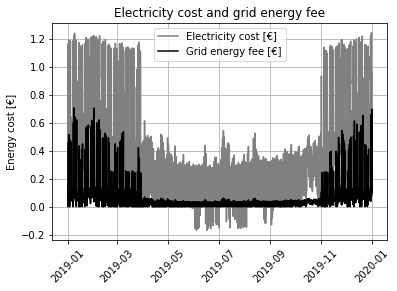

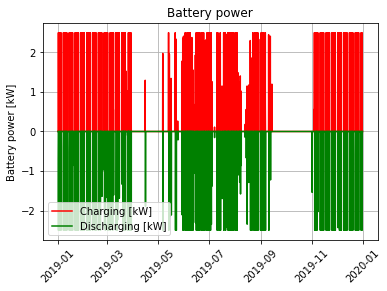

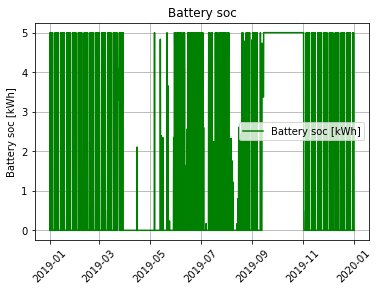

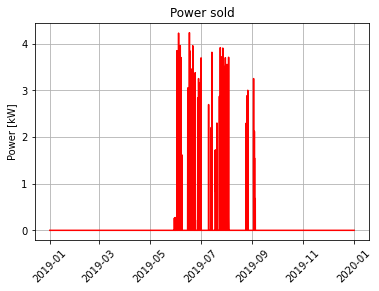

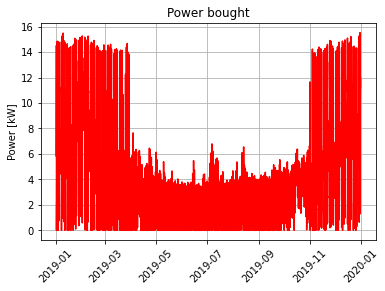

In [54]:
# Make plots

plt.plot(df['cost_energy'],color = 'gray')
plt.plot(df['cost_grid_energy_import']+df['cost_grid_energy_export'],color = 'black')
plt.xticks(rotation = 45)
plt.ylabel('Energy cost [€]')
plt.title('Electricity cost and grid energy fee')
plt.legend(['Electricity cost [€]','Grid energy fee [€]'])
plt.grid()
plt.show()

plt.plot(df['battery_charge'],color = 'red')
plt.plot(-df['battery_discharge'],color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('Battery power [kW]')
plt.title('Battery power')
plt.legend(['Charging [kW]','Discharging [kW]'])
plt.grid()
plt.show()

plt.plot(df['battery_soc'],color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('Battery soc [kWh]')
plt.title('Battery soc')
plt.legend(['Battery soc [kWh]'])
plt.grid()
plt.show()

plt.plot(df['power_sell'],color = 'red')
plt.xticks(rotation = 45)
plt.ylabel('Power [kW]')
plt.title('Power sold')
plt.grid()
plt.show()

plt.plot(df['power_buy'],color = 'red')
plt.xticks(rotation = 45)
plt.ylabel('Power [kW]')
plt.title('Power bought')
plt.grid()
plt.show()

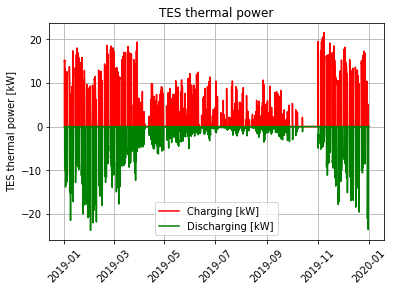

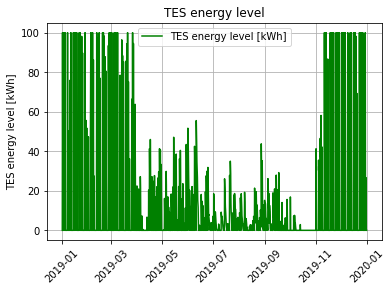

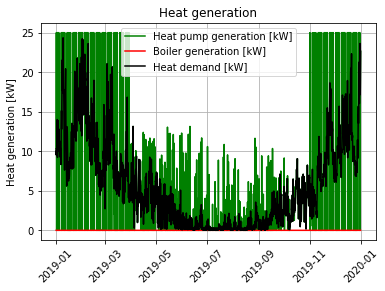

In [55]:
plt.plot(df['tes_charge'],color = 'red')
plt.plot(-df['tes_discharge'],color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('TES thermal power [kW]')
plt.title('TES thermal power')
plt.legend(['Charging [kW]','Discharging [kW]'])
plt.grid()
plt.show()

plt.plot(df['tes_soc'],color = 'green')
plt.xticks(rotation = 45)
plt.ylabel('TES energy level [kWh]')
plt.title('TES energy level')
plt.legend(['TES energy level [kWh]'])
plt.grid()
plt.show()


plt.plot(df['heat_pump_heat_generation'],color = 'green')
plt.plot(df['boiler_heat_generation'],color = 'red')
plt.plot(df['Heat'],color = 'black')
plt.xticks(rotation = 45)
plt.ylabel('Heat generation [kW]')
plt.title('Heat generation')
plt.legend(['Heat pump generation [kW]','Boiler generation [kW]','Heat demand [kW]'])
plt.grid()
plt.show()

The total operation cost for 2019 is:

In [56]:
print(results['cost_total'])

3665.0358584626474
